# Optimizing a variational quantum circuit via simulated annealing
by Mahnoor Fatima

**Simulated annealing** is an optimization algorithm to find the global optima for both bounded and unbounded optimization problems. The algorithm is inspired from the metallic annealing process in which a metal is first heated and then gradually cooled. In this algorithm, the optimizer first explores the solution space haphazardly which allows it to explore a greater range of values; as the temperature 'drops,' the solution space becomes less scattered and the predicted points remain close to the current state of the system.

The main advantage is that it allows the determination of the stochastic global maximum of an optimization problem. However, the dowside of this algorithm is that it might return the wrong optimal point.

You can read more about simulated annealing and its applications in this [open-source paper](https://projecteuclid.org/journals/statistical-science/volume-8/issue-1/Simulated-Annealing/10.1214/ss/1177011077.full).

## Explore the Problem Statement

A variational quantum circuit (VQC) is a quantum circuit having parametrized gates such that the behaviour of the circuit can be varied by varying the parameters. Thus, with appropriate parameters, a generic parametrized quantum circuit can be trained to perform a desired operation.

This flexibility of VQCs is the inspiration for this problem: training a *n*-qubit VQC for evaluating the Quantum Fourier Transform of a number in the range $0$ to $2^n - 1$. The Quantum Fourier Transform (QFT) is itself a unitary operation which evaluates the Fourier transform of a quantum state.

For this challenge, you will be making a generic *n*-qubit variational quantum circuit with Hadamard gates and $R_z(\theta)$ gates applied to each qubit. The angles $\theta$ for each $R_z$ gate comprise the list of parameters to be optimized. An inverse-QFT block is applied to evaluate the error such that the expected output is the input number itself.

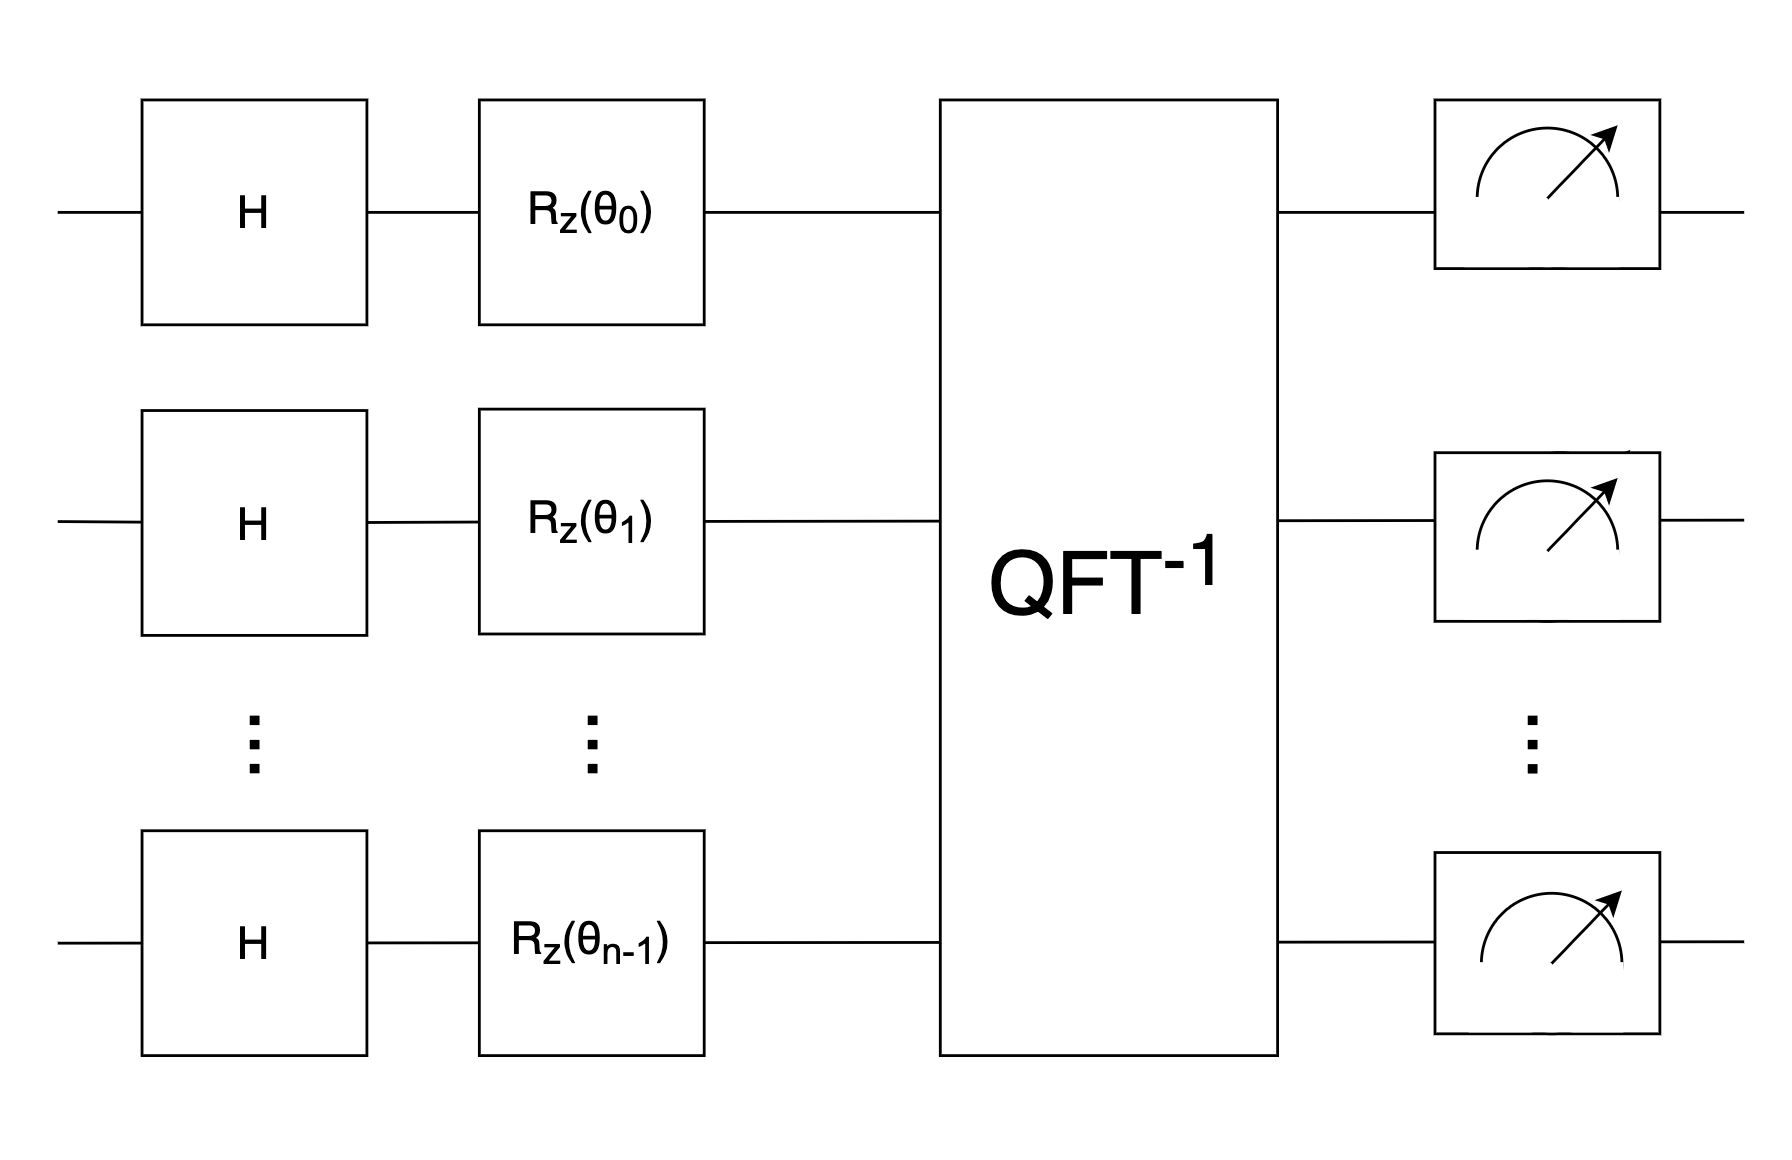

## Import the libraries and define the device

In [2]:
import pennylane as qml
from pennylane import numpy as np
from math import exp

In [10]:
n = 1
dev = qml.device('default.qubit', wires = n)

## Define the quantum node and circuit

Use the above image to form the quantum circuit. You will need the Hadamard and [RZ](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html) gates. You will also need [qml.adjoint](https://docs.pennylane.ai/en/stable/code/api/pennylane.adjoint.html), [qml.QFT](https://docs.pennylane.ai/en/stable/code/api/pennylane.QFT.html), and [qml.probs](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html).

In [11]:
@qml.qnode(dev)
def circuit(theta):
    for i in range(n):
        qml.Hadamard(wires = i)
        qml.RZ(theta[i], wires = i)
    qml.adjoint(qml.QFT)(wires=range(n))
    return qml.probs(wires = range(n))

## Define the cost function

The **Mean Square Error (MSE)** is one of the most common cost functions and is given by:

<p style="text-align: center">
    $MSE = \sum_{i=0}^{N-1} (y_i-\hat{y}_i)^2$
</p>

where $y$ is the predicted output array and $\hat{y}$ is the expected output array.

For the given problem, the expected output $\hat{y}$ is a $2^n$-sized array with all entries equal to zero except for the $m$-index entry, which is $1$, i.e., we want the number $m$ to be evaluated with an absolute certainty.

In [12]:
def cost(params):
    y = np.zeros(2**n)
    y[m] = 1
    probs = circuit(params)
    return np.sum(np.square((y-probs)))

## Implement the Simulated Annealing Algorithm

The procedure for simulated annealing is as follows:

- A random point is selected as the initial state of the system.

- As the temperature is initially high, the algorithm searches the solution space haphazardly and evaluates the cost value for various states. If the cost value for a certain state is less than for the current optimal state, the optimal state of the circuit is updated.

The new temperature of the system is evaluated by using the following equation:

<p style="text-align: center">
    $t_{i} = \frac{t_o}{i+1}$
</p>

where $i$ is the number of the current iteration.

As the temperature of the system decreases, the algorithm takes smaller strides across the solution space.

Fill in the blanks in the below algorithm:

In [13]:
def simulated_annealing(objective, param_range, temperature, iterations, learning_rate):
        # Define initial state
        s0 = np.empty(np.shape(param_range)[0])
        s_eval = 0 
        for i in range(len(s0)):
            s0[i] = param_range[i][0] + np.random.random()* (param_range[i][1] - param_range[i][0])

        # Evaluate current state of the system 
        s = s0
        s_eval = objective(s0)

        for k in range(iterations):
            # Find a candidate element
            s_new = np.empty(np.shape(param_range)[0])
            for i in range(len(s_new)):
                rng = param_range[i][1] - param_range[i][0]     # Range of the variable
                s_new[i] = s[i] + np.random.uniform(param_range[i][0] - rng/2, param_range[i][0] + rng/2)*learning_rate

            # Evaluate the candidate element        
            s_new_eval = objective(s_new)
            # Update the state of the system
            if s_new_eval < s_eval:
                s = s_new
                s_eval = s_new_eval

            delta = s_new_eval - s_eval
            t = temperature/float(k+1) 

            # Metropolis acceptance criterion
            metropolis = exp(-delta/t)
            if metropolis > np.random.uniform():
                s = s_new
                s_eval = s_new_eval
        return s, s_eval

## Optimization module

As a final step of implementing the solution of the given problem, the entire optimization problem is encapsulated in a function. This allows to quick-run the problem for different parameters without the hassle of updating the parameters. Also, the quantum circuit has been defined within the function to keep the variables (like $m$ and $n$) accessible for all functions.

Fill in your code below the task descriptions:

In [14]:
def quantum_fourier_transform(n, m, temperature, steps = 5000, learning_rate = 0.01):
    ''' A function to generate the Quantum Fourier Transform of a number m via a quantum circuit with n-qubits. 
    
    Args:
    n: It is the number of qubits in the variational quantum circuit.
    m: It is the number used to train the variational quantum circuit. Its value ranges from 0 to 2^n - 1
    steps: It is the number of iterations of the optimzation process.
    learning_rate: This is the step size of the optimizer.
    
    Return value:
    circuit: The variational quantum circuit comprising n qubits.
    param_arr: Shape = (steps, n). It consists of the values of the parameters after each optimization step.
    cost_arr: Size = n. It consists of the cost value of the circuit after each optimization step.
    cost: The cost function
    '''
    # Task 2: Load a Quantum Device
    dev = qml.device('default.qubit', wires = n)
    
    # Task 3-6: Create the Quantum Circuit
    @qml.qnode(dev)
    def circuit(theta):
        for i in range(n):
            qml.Hadamard(wires = i)
            qml.RZ(theta[i], wires = i)
        qml.adjoint(qml.QFT)(wires=range(n))
        return qml.probs(wires = range(n))
    
    # Task 7: Create the Cost Function
    def cost(params):
        y = np.zeros(2**n)
        y[m] = 1
        probs = circuit(params)
        return np.sum(np.square((y-probs)))
    
    # Defining the bounds of the angles
    bounds = np.empty((n, 2))
    for bound in bounds:
        bound[0] = 0
        bound[1] = 2*np.pi
        
    angles, cost = simulated_annealing(cost, bounds, temperature, steps, learning_rate)
    angles = angles%(np.pi*2)

    # Print the results of optimization
    print("Optimized rotation angles: ", angles)
    print("Cost value at optimized parameters: ",cost)
    
    return circuit, angles, cost

## Optimization of the Quantum Circuit

Now, test-run the function for a random set of parameters to evaluate it's performance.

Optimized rotation angles:  [2.80314255 4.82725244]
Cost value at optimized parameters:  0.0014142336945561428


(<Figure size 600x300 with 1 Axes>, <Axes: >)

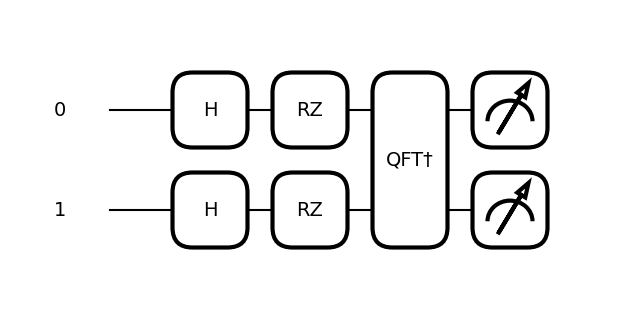

In [15]:
circuit, angles, cost = quantum_fourier_transform(2, 3, 5, steps = 10000, learning_rate = 0.01)
qml.draw_mpl(circuit)(angles)